Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model



## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [19]:
dataframe.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,-0.586130,-0.434278,-0.337449,-0.258099,-0.184456,-0.120129,-0.070506,-0.041937,-0.037130,-0.041337,-0.049010,-0.060307,-0.070843,-0.085600,-0.101286,-0.116194,-0.134578,-0.155946,-0.177672,-0.200843,-0.224423,-0.246854,-0.271651,-0.290474,-0.304663,-0.315294,-0.317019,-0.313238,-0.303382,-0.287468,...,1.051536,1.138315,1.187783,1.202143,1.191057,1.154773,1.086526,0.987001,0.864503,0.720300,0.569957,0.428874,0.319608,0.242431,0.180869,0.134522,0.109577,0.093447,0.080869,0.065658,0.047197,0.025245,0.004376,-0.009969,-0.019308,-0.026427,-0.029722,0.000602,0.086755,0.146633,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,0.591967,0.493568,0.426136,0.393470,0.382495,0.386314,0.400829,0.415265,0.423789,0.429737,0.434978,0.441769,0.447734,0.454604,0.461603,0.472735,0.483584,0.492048,0.503456,0.516152,0.530018,0.543060,0.552284,0.560660,0.564907,0.566459,0.560786,0.548962,0.536246,0.517517,...,0.574648,0.614846,0.623061,0.608324,0.582758,0.553968,0.531302,0.507281,0.485679,0.483575,0.511429,0.546471,0.565638,0.572041,0.573811,0.584503,0.589670,0.591625,0.597142,0.603989,0.610285,0.619744,0.633055,0.649124,0.667342,0.680240,0.693360,0.751323,0.919556,1.170839,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,-4.040526,-3.724538,-3.264576,-3.222345,-3.263484,-3.219212,-3.202187,-3.147504,-3.459917,-4.102102,-4.311241,-4.099888,-3.614973,-3.822298,-3.795567,-3.690817,-3.542485,-3.631665,-3.587112,-3.452215,-4.074752,-4.137454,-4.059662,-3.626646,-2.829471,-3.585866,-4.003401,-3.900724,-3.325329,-3.911093,...,-2.634950,-2.634768,-2.591663,-2.446476,-2.234175,-2.431403,-2.681604,-2.864706,-3.415656,-3.497624,-3.091282,-2.608510,-2.383204,-2.678883,-3.305661,-3.179590,-3.311559,-3.501555,-4.007212,-4.199563,-3.335678,-3.127603,-3.042532,-3.116177,-3.972320,-4.754057,-4.290016,-3.802469,-4.014642,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,-0.935581,-0.704545,-0.557786,-0.457045,-0.392050,-0.346571,-0.330078,-0.332150,-0.342887,-0.359614,-0.373584,-0.392696,-0.415363,-0.441361,-0.470725,-0.501688,-0.538308,-0.570269,-0.616870,-0.650657,-0.695510,-0.735157,-0.771070,-0.800239,-0.812346,-0.827283,-0.815851,-0.796261,-0.762420,-0.714294,...,0.637826,0.665319,0.688332,0.70

In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [4]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [5]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

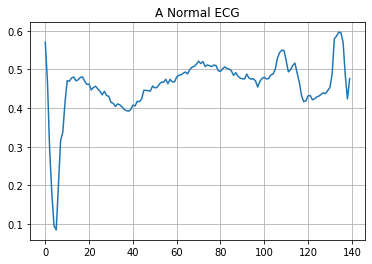

In [6]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

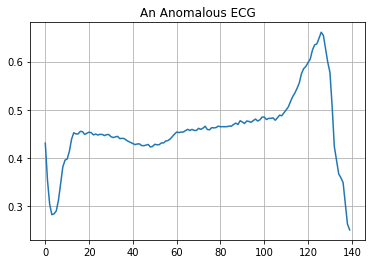

In [7]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [59]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [60]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [61]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
3/3 [==============================] - 1s 69ms/step - loss: 0.0583 - val_loss: 0.0533
Epoch 2/20
3/3 [==============================] - 0s 17ms/step - loss: 0.0568 - val_loss: 0.0522
Epoch 3/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0551 - val_loss: 0.0510
Epoch 4/20
3/3 [==============================] - 0s 17ms/step - loss: 0.0531 - val_loss: 0.0496
Epoch 5/20
3/3 [==============================] - 0s 15ms/step - loss: 0.0508 - val_loss: 0.0484
Epoch 6/20
3/3 [==============================] - 0s 17ms/step - loss: 0.0483 - val_loss: 0.0474
Epoch 7/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0459 - val_loss: 0.0459
Epoch 8/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0436 - val_loss: 0.0446
Epoch 9/20
3/3 [==============================] - 0s 15ms/step - loss: 0.0414 - val_loss: 0.0436
Epoch 10/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0394 - val_loss: 0.0428
Epoch 11/20
3/3 [============

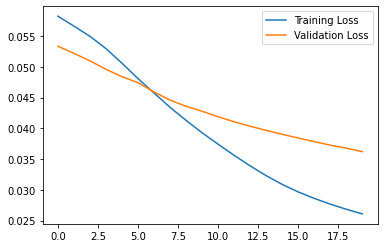

In [62]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

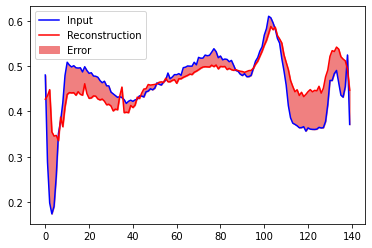

In [63]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

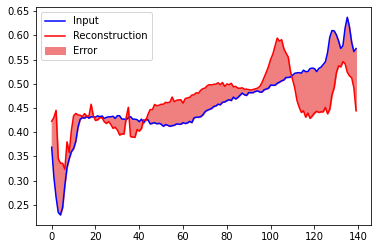

In [64]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

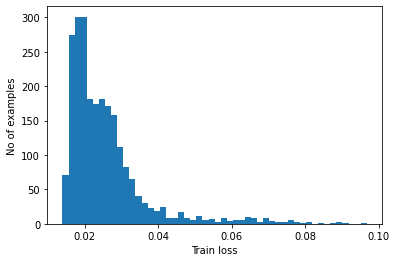

In [65]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [66]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0366093


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

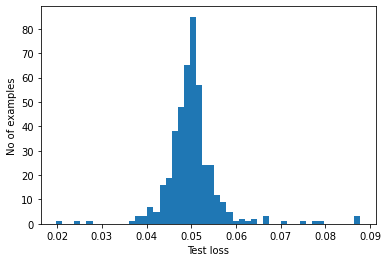

In [67]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [68]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [69]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

## epochs=20, batch_size=512
# Accuracy = 0.945
# Precision = 0.9922027290448343
# Recall = 0.9089285714285714

#           # epochs=20, 
#           # batch_size=512*2,
# Accuracy = 0.944
# Precision = 0.9941176470588236
# Recall = 0.9053571428571429


# # epochs=30, 
# # batch_size=512,
# Accuracy = 0.939
# Precision = 0.994059405940594
# Recall = 0.8964285714285715

Accuracy = 0.944
Precision = 0.9941176470588236
Recall = 0.9053571428571429


In [97]:
2/(1/(0.9941176470588236)+1/(0.9053571428571429))

0.9476635514018691

Batch size impacts learning significantly. What happens when you put a batch through your network is that you average the gradients. The concept is that if your batch size is big enough, this will provide a stable enough estimate of what the gradient of the full dataset would be. By taking samples from your dataset, you estimate the gradient while reducing computational cost significantly. The lower you go, the less accurate your esttimate will be, however in some cases these noisy gradients can actually help escape local minima. When it is too low, your network weights can just jump around if your data is noisy and it might be unable to learn or it converges very slowly, thus negatively impacting total computation time.

Another advantage of batching is for GPU computation, GPUs are very good at parallelizing the calculations that happen in neural networks if part of the computation is the same (for example, repeated matrix multiplication over the same weight matrix of your network). This means that a batch size of 16 will take less than twice the amount of a batch size of 8.

In the case that you do need bigger batch sizes but it will not fit on your GPU, you can feed a small batch, save the gradient estimates and feed one or more batches, and then do a weight update. This way you get a more stable gradient because you increased your virtual batch size.

## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.


In [71]:
dataframe.shape

(4998, 141)

# **Compare** LogisticRegression

similar Accuracy

In [75]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, accuracy_score  # log_loss
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [103]:
def gs(X, y, m, param, scoring, cv, n_jobs):
    GridSearch = GridSearchCV(m, param, scoring=scoring, cv=cv, n_jobs=n_jobs)
    GridSearch.fit(X=X, y=y)
    model = GridSearch.best_estimator_
    print('best_score_:', GridSearch.best_score_, GridSearch.best_params_)
    return model

def classify_LR(y, X, seed=2020, scoring='f1', cv=5, n_jobs=4):
    cols = X.columns
    param = {'C': [10**-1, 10**0, 10]}
    m = LogisticRegression(class_weight='balanced',
                           solver='liblinear', tol=0.001, random_state=seed)
    model = gs(X, y, m, param, scoring=scoring, cv=cv, n_jobs=n_jobs)
    coef = pd.DataFrame(list(zip(cols, np.round(
        model.coef_[0], 2))), columns=['Variable', 'coef_'])
    coef['imp'] = coef['coef_'].abs()
    return model, coef.sort_values('imp', ascending=False)


# The last element contains the labels
y = raw_data[:, -1]
# The other data points are the electrocadriogram data
X = raw_data[:, 0:-1]
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, random_state=21
)


min_max_scaler = StandardScaler()  # MinMaxScaler()
Xtrain_ = min_max_scaler.fit_transform(Xtrain)
Xtest = min_max_scaler.transform(Xtest)
Xtrain = pd.DataFrame(Xtrain_)
m, imp = classify_LR(ytrain, Xtrain)
ytest_pred = m.predict(Xtest)

# 5 folds cv
# roc_auc best_score_: 0.9971233243611535 {'C': 0.1}
# f1 best_score_: 0.9899175097774314 {'C': 1}  


# test score
print_stats(ytest_pred, ytest)
# # 5 folds train cv f1 best_score_: 0.9902540924105724 {'C': 0.1}
# Accuracy = 0.944
# Precision = 0.9941176470588236
# Recall = 0.9053571428571429

best_score_: 0.9902540924105724 {'C': 0.1}
Accuracy = 0.944
Precision = 0.9941176470588236
Recall = 0.9053571428571429


array([1., 1., 1., ..., 0., 0., 0.])

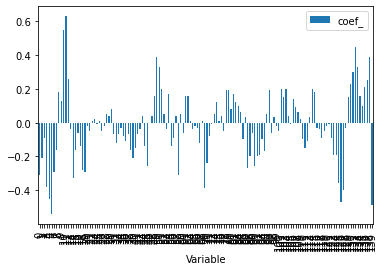

In [101]:
imp.sort_index().plot(kind='bar', x='Variable', y='coef_')

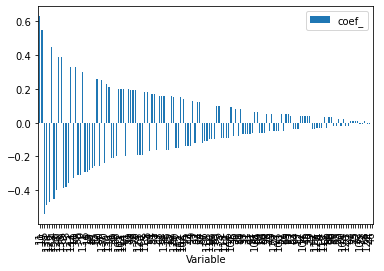

In [100]:
imp.plot(kind='bar', x='Variable', y='coef_')